In [192]:
import matplotlib.pyplot as plt
import numpy as np


In [30]:
NR_AGENTS = 17000
NR_AGENTS_MEAN = 17000
NR_AGENTS_STD = 5000
PROBABILITY_CLIENT = 0.25
BUY_INTENTION_CONCENTRATION1 = 2.0
BUY_INTENTION_CONCENTRATION2 = 7.0
NR_VISITS_TOTAL_COUNT = 1.0

In [149]:
import torch as th
import torch.distributions as D
from dataclasses import dataclass

th.set_printoptions(precision=2, sci_mode=False)


@dataclass
class PopulationModel:
    intention: D.Beta
    is_client: D.Bernoulli
    weights: th.nn.Parameter | None = None

    def sample(self, discount, N):
        intention = self.intention.sample((N, 1))
        is_client = self.is_client.sample((N, 1))
        # the number of visits should be correlated with the intention
        visit_cnt = D.NegativeBinomial(th.tensor(NR_VISITS_TOTAL_COUNT), intention).sample()
        discount = th.full_like(visit_cnt, discount)

        return th.cat([intention, is_client, visit_cnt, discount], dim=1)

    @classmethod
    def init(cls):
        return cls(
            D.Beta(th.tensor(BUY_INTENTION_CONCENTRATION1), th.tensor(BUY_INTENTION_CONCENTRATION2)),  # 0.2 intention on average
            D.Bernoulli(probs=th.tensor(PROBABILITY_CLIENT)),  # assume 1/4 visitors are clients
        )
    
    def load_weights(self, file_path):
        loaded_weights = th.load(file_path)
        self.weights = th.nn.Parameter(loaded_weights)

    def save_weights(self, file_path="weights_population_model.pth"):
        if self.weights is not None:
            th.save(self.weights, file_path)
        else:
            raise ValueError("No weights to save. You need to fit the model first.")


    def fit(self, target=0.008, batch_size=10_000, k=2):
        self.weights = th.nn.Parameter(th.randn(4 * k, 1))
        optim = th.optim.Adam([self.weights])
        target_dist = D.Bernoulli(target)
        discounts = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

        for i in range(20_000):
            todays_discount = discounts[th.randint(len(discounts), (1,)).item()]
            x = self.sample(todays_discount, batch_size)
            phi = self._make_features(x, k)
            y = th.sigmoid(phi @ self.weights)

            targets = target_dist.sample((batch_size, 1))
            loss = th.nn.functional.binary_cross_entropy(y, targets)

            optim.zero_grad()
            loss.backward()
            optim.step()

            if i % 1000 == 0:
                print(
                    "{:06d}) ratio={:.3f}, loss={:.2f}  |  {}".format(
                        i,
                        y.mean().item(),
                        loss.item(),
                        self.weights.flatten().detach(),
                    )
                )

    @staticmethod
    def _make_features(x, k):
        phi = th.cat([x.pow(i) for i in range(1, k + 1)], dim=1)
        return (phi - phi.mean(dim=1, keepdim=True)) / phi.std(dim=1, keepdim=True)

    @th.no_grad()
    def act(self, sample):
        assert (
            self.weights is not None
        ), "Before using `act()` you first have to call PopulationModel.learn()"
        phi = self._make_features(sample, self.weights.shape[0] // sample.shape[1])
        return D.Bernoulli(th.sigmoid(phi @ self.weights)).sample()


#### Learn the optimal weights

In [151]:
pop_dist = PopulationModel.init()
pop_dist.fit()

000000) ratio=0.359, loss=0.84  |  tensor([-0.47,  1.63,  0.79,  0.19,  1.04,  1.10,  1.78,  0.31])
001000) ratio=0.226, loss=0.30  |  tensor([ 0.07,  0.98,  0.37, -0.14,  1.87,  0.45,  1.00,  1.02])
002000) ratio=0.109, loss=0.14  |  tensor([-0.13,  0.78,  0.52, -0.63,  2.43,  0.25,  0.49,  1.48])
003000) ratio=0.076, loss=0.10  |  tensor([-0.42,  0.65,  0.70, -0.98,  2.87,  0.12,  0.10,  1.84])
004000) ratio=0.042, loss=0.07  |  tensor([-0.68,  0.56,  0.86, -1.28,  3.26,  0.03, -0.22,  2.13])
005000) ratio=0.025, loss=0.06  |  tensor([-0.95,  0.48,  0.99, -1.51,  3.60, -0.05, -0.48,  2.38])
006000) ratio=0.018, loss=0.06  |  tensor([-1.22,  0.40,  1.07, -1.67,  3.92, -0.13, -0.70,  2.62])
007000) ratio=0.029, loss=0.07  |  tensor([-1.44,  0.36,  1.16, -1.83,  4.23, -0.17, -0.87,  2.79])
008000) ratio=0.011, loss=0.06  |  tensor([-1.64,  0.31,  1.21, -1.91,  4.49, -0.22, -1.02,  2.95])
009000) ratio=0.023, loss=0.05  |  tensor([-1.82,  0.27,  1.25, -1.96,  4.70, -0.26, -1.13,  3.06])


In [163]:
pop_dist.save_weights("weights_population_model_0.8_ratio.pth")


#### Compute nr orders per day

In [37]:
def orders_and_rate_per_day(pop_dist, discount_sample, fixed_agents=True, nr_agents=NR_AGENTS):
    if fixed_agents:
        agents = pop_dist.sample(discount_sample, nr_agents)

    else:
        nr_agents_distribution = D.Normal(NR_AGENTS_MEAN, NR_AGENTS_STD)

        nr_agents = int(nr_agents_distribution.sample())
        agents = pop_dist.sample(discount_sample, nr_agents)

    result = pop_dist.act(agents)

    return float(th.sum(result)), float(result.mean())

In [189]:
orders_and_rate_per_day(pop_dist, 0.3)

(125.0, 0.007352941203862429)

## Multi armed bandits


In [65]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import math

In [68]:
PROUDCT_PRICE = 300

In [133]:
class EpsilonGreedyMAB:
    def __init__(self, n_arms, epsilon):
        self.n_arms = n_arms
        self.epsilon = epsilon
        self.counts = np.zeros(n_arms)  # Number of times each arm was pulled
        self.values = np.zeros(n_arms)  # Estimated value (mean reward) for each arm

    def select_arm(self):
        if np.random.rand() < self.epsilon:
            return np.random.randint(0, self.n_arms)
        else:
            return np.argmax(self.values)

    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] += 1
        n = self.counts[chosen_arm]
        value = self.values[chosen_arm]
        new_value = ((n - 1) / n) * value + (1 / n) * reward
        self.values[chosen_arm] = new_value

class RandomStrategy:
    def __init__(self, n_arms):
        self.n_arms = n_arms
        self.counts = np.zeros(n_arms)
        self.values = np.zeros(n_arms)

    def select_arm(self):
        return np.random.randint(0, self.n_arms)

    def update(self, chosen_arm, reward):
        pass  # Random strategy does not learn, so no update is needed

class UCB:
    def __init__(self, n_arms, confidence):
        self.confidence = confidence
        self.n_arms = n_arms
        self.counts = np.zeros(n_arms)  # Number of times each arm was pulled
        self.values = np.zeros(n_arms)  # Estimated value (mean reward) for each arm

    def select_arm(self):
        n_arms = len(self.counts)
        for arm in range(n_arms):
            if self.counts[arm] == 0:
                return arm
    
        ucb_values = [0.0 for _ in range(n_arms)]
        total_counts = sum(self.counts)
        
        for arm in range(n_arms):
            bonus = math.sqrt((math.log(total_counts)) / float(self.counts[arm]))
            ucb_values[arm] = self.values[arm] + self.confidence * bonus
        return ucb_values.index(max(ucb_values))
    

    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] += 1
        n = self.counts[chosen_arm]
        value = self.values[chosen_arm]
        new_value = ((n - 1) / n) * value + (1 / n) * reward
        self.values[chosen_arm] = new_value


def simulate(algorithm='epsilon_greedy', discounts=[0.3, 0.5, 0.8],  n_days=10, epsilon=0.1, reward='orders'):
    n_arms = len(discounts)
    # discounts = [0.3, 0.5, 0.8]  
    if algorithm == 'epsilon_greedy':
        mab = EpsilonGreedyMAB(n_arms, epsilon)
    elif algorithm == 'random':
        mab = RandomStrategy(n_arms)
    elif algorithm == 'UCB':
        mab = UCB(n_arms, epsilon)

    rewards_per_day = np.zeros(n_days)

    for day in range(n_days):
        chosen_arm = mab.select_arm()
        discount = discounts[chosen_arm]

        # Simulate the buying process
        orders, rate = orders_and_rate_per_day(pop_dist, discount)

        if reward == 'orders':
            mab.update(chosen_arm, orders)
            rewards_per_day[day] = orders
        elif reward == 'rate':
            mab.update(chosen_arm, rate)
            rewards_per_day[day] = rate
        elif reward == 'profit':
            profit = orders * (1 - discount) * PROUDCT_PRICE
            mab.update(chosen_arm, profit)
            rewards_per_day[day] = profit
        # print(f"Rewards day {day}: {reward} for discount {discount}")

    return rewards_per_day, mab.values, mab.counts


In [114]:
def plot_average_rewards(n_days, epsilons, num_runs, discounts, reward):

    average_rewards = np.zeros((len(epsilons), n_days))
    average_values = []
    average_counts = []

    # Run simulations Epsilon Greedy 
    for i, epsilon in enumerate(epsilons):
        all_rewards = np.zeros((num_runs, n_days))
        all_values = []
        all_counts = []

        for run in tqdm(range(num_runs)):
            rewards, values, counts = simulate('epsilon_greedy', discounts, n_days, epsilon, reward=reward)
            all_rewards[run] = rewards
            all_values.append(list(values))
            all_counts.append(list(counts))
        
        all_values = np.array(all_values)
        average_rewards[i] = np.mean(all_rewards, axis=0)
        average_values.append(np.mean(all_values, axis=0))
        average_counts.append(np.mean(all_counts, axis=0))

    # Run simulations random
    all_rewards_random = np.zeros((num_runs, n_days))
    all_values_random = []
    all_counts_random = []

    for run in tqdm(range(num_runs)):
        rewards, values, counts = simulate('epsilon_greedy', discounts, n_days, epsilon=1, reward=reward)
        all_rewards_random[run] = rewards
        all_values_random.append(list(values))
        all_counts_random.append(list(counts))

    all_values_random = np.array(all_values_random)
    average_rewards_random = np.mean(all_rewards_random, axis=0)
    average_values_random = np.mean(all_values_random, axis=0)
    average_counts_random = np.mean(all_counts_random, axis=0)

    # Plotting
    fig = plt.figure(figsize=(14, 5))

    for i, epsilon in enumerate(epsilons):
        plt.plot(average_rewards[i], label=f'epsilon = {epsilon}')

    plt.plot(average_rewards_random, linestyle='dashed', label=f'random')

    plt.xlabel('Steps')
    plt.ylabel(f'Average Reward ({reward})')
    plt.title('Average Rewards Over Time for Different Epsilon Values')
    plt.legend()
    plt.show()

    plt.tight_layout()
    plt.show()

    return average_rewards, average_rewards_random, average_values, average_values_random, \
        average_counts, average_counts_random

#### Maximize nr of orders

100%|██████████| 30/30 [02:42<00:00,  5.42s/it]


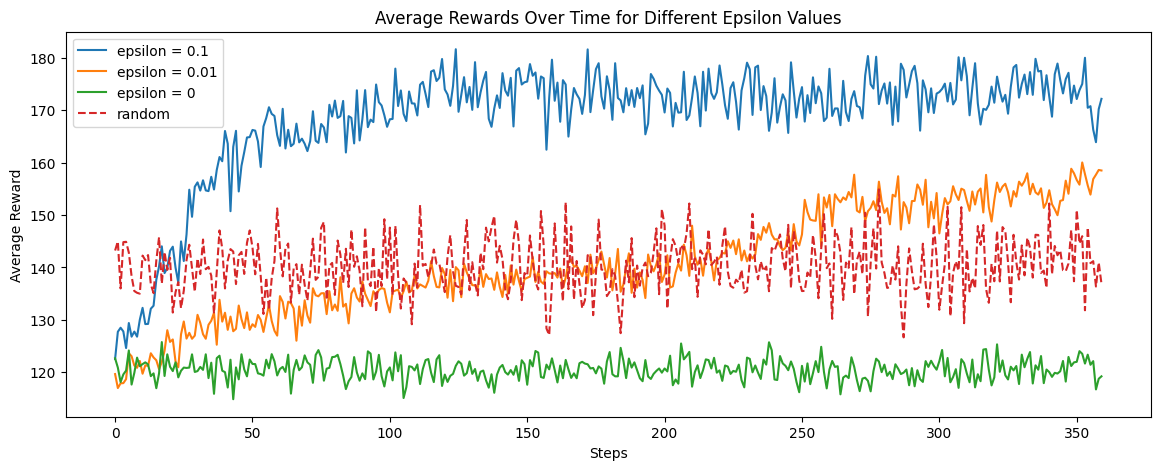

<Figure size 640x480 with 0 Axes>

In [66]:
average_rewards, average_rewards_random = plot_average_rewards(n_days=360, epsilons=[0.1, 0.01, 0], num_runs=30,\
                                                                discounts=[0.3, 0.4, 0.5, 0.6, 0.7, 0.8], reward='orders')

100%|██████████| 30/30 [00:17<00:00,  1.73it/s]


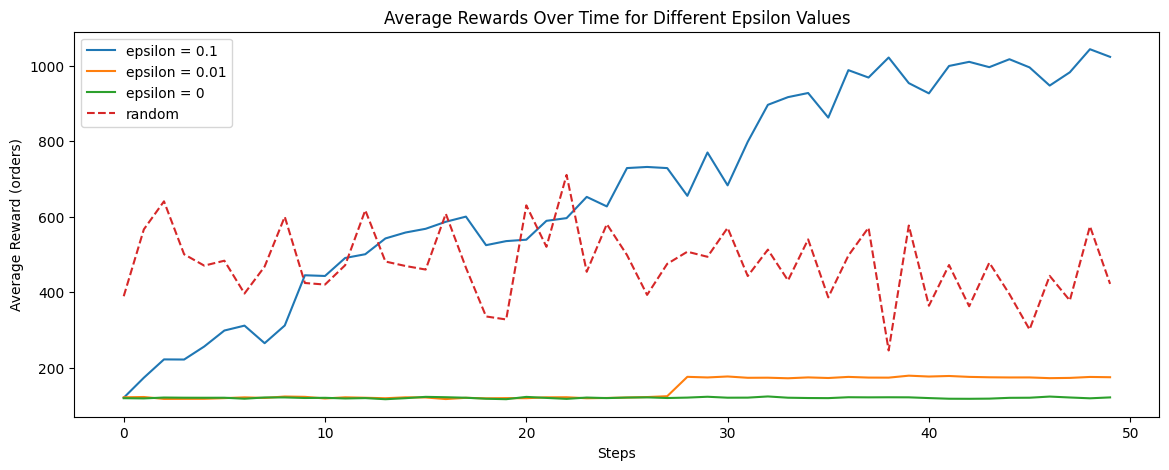

<Figure size 640x480 with 0 Axes>

In [115]:
average_rewards, average_rewards_random, average_values, average_values_random, average_counts, average_counts_random =\
      plot_average_rewards(n_days=50, epsilons=[0.1, 0.01, 0], num_runs=30,\
      discounts=[0.3, 0.4, 0.5, 0.6, 0.7, 0.8], reward='orders')

In [117]:
print("Rewards:", average_rewards, average_rewards_random)
print("\nValues:", average_values, average_values_random)
print("\nCounts:", average_counts, average_counts_random)

Rewards: [[ 120.53333333  173.53333333  222.03333333  221.7         256.2
   298.46666667  311.43333333  264.96666667  311.83333333  444.76666667
   442.9         490.53333333  500.46666667  542.23333333  557.93333333
   567.8         586.36666667  600.          524.43333333  535.16666667
   538.93333333  588.86666667  596.03333333  652.23333333  627.
   728.53333333  731.46666667  728.46666667  655.06666667  769.76666667
   682.76666667  798.13333333  895.93333333  916.3         927.23333333
   862.13333333  987.7         968.16666667 1021.16666667  953.4
   926.26666667  998.83333333 1009.73333333  995.63333333 1016.63333333
   995.          946.93333333  982.06666667 1043.13333333 1022.93333333]
 [ 121.73333333  122.5         117.46666667  117.63333333  117.8
   119.5         121.6         120.          123.8         122.93333333
   118.63333333  121.73333333  120.53333333  119.23333333  121.66666667
   121.26666667  117.06666667  120.36666667  118.96666667  119.56666667
   119.3333

#### Maximize profit

100%|██████████| 30/30 [00:15<00:00,  1.90it/s]


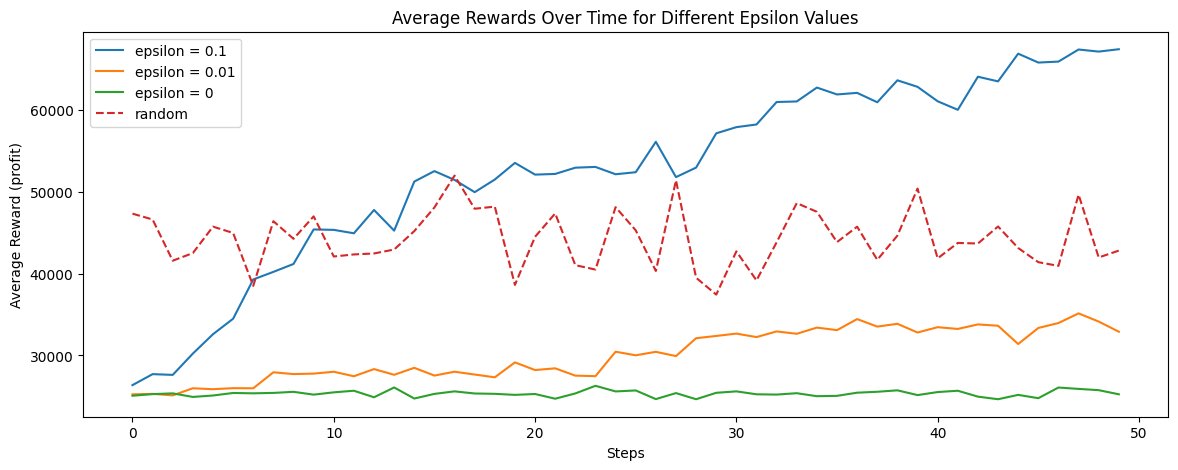

<Figure size 640x480 with 0 Axes>

In [118]:
average_rewards, average_rewards_random, average_values, average_values_random, average_counts, average_counts_random =\
      plot_average_rewards(n_days=50, epsilons=[0.1, 0.01, 0], num_runs=30,\
      discounts=[0.3, 0.4, 0.5, 0.6, 0.7, 0.8], reward='profit')

In [119]:
print("Rewards:", average_rewards, average_rewards_random)
print("\nValues:", average_values, average_values_random)
print("\nCounts:", average_counts, average_counts_random)

Rewards: [[26375. 27716. 27627. 30228. 32592. 34484. 39280. 40205. 41171. 45385.
  45336. 44916. 47764. 45242. 51233. 52512. 51436. 49939. 51482. 53514.
  52083. 52165. 52929. 53021. 52127. 52374. 56091. 51779. 52941. 57125.
  57879. 58204. 60949. 61016. 62713. 61871. 62065. 60917. 63599. 62802.
  61037. 59998. 64037. 63469. 66853. 65767. 65884. 67360. 67106. 67395.]
 [25249. 25307. 25126. 25991. 25878. 26004. 25991. 27942. 27724. 27782.
  28008. 27460. 28336. 27637. 28490. 27543. 28013. 27668. 27330. 29151.
  28218. 28426. 27535. 27471. 30455. 30018. 30442. 29921. 32105. 32380.
  32667. 32241. 32934. 32645. 33400. 33092. 34440. 33524. 33862. 32800.
  33451. 33237. 33789. 33627. 31395. 33355. 33958. 35137. 34136. 32896.]
 [25081. 25277. 25368. 24934. 25109. 25417. 25375. 25424. 25557. 25214.
  25494. 25690. 24892. 26089. 24738. 25305. 25613. 25354. 25312. 25186.
  25291. 24717. 25361. 26292. 25606. 25725. 24668. 25403. 24654. 25438.
  25613. 25256. 25221. 25389. 25025. 25067. 25452. 25

#### Maximize rate

100%|██████████| 30/30 [00:17<00:00,  1.71it/s]


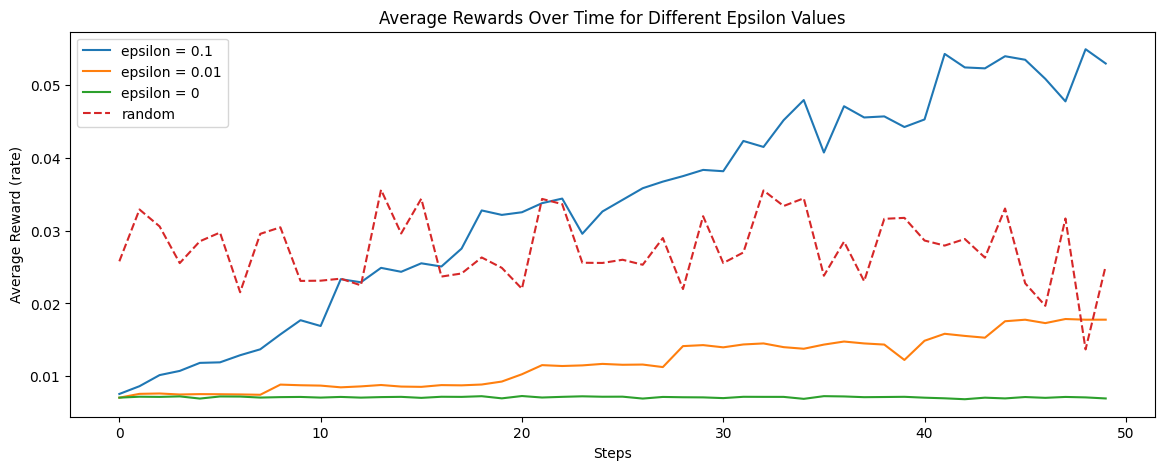

<Figure size 640x480 with 0 Axes>

In [120]:
average_rewards, average_rewards_random, average_values, average_values_random, average_counts, average_counts_random =\
      plot_average_rewards(n_days=50, epsilons=[0.1, 0.01, 0], num_runs=30,\
      discounts=[0.3, 0.4, 0.5, 0.6, 0.7, 0.8], reward='rate')

In [121]:
print("Rewards:", average_rewards, average_rewards_random)
print("\nValues:", average_values, average_values_random)
print("\nCounts:", average_counts, average_counts_random)

Rewards: [[0.00755098 0.00861765 0.0101451  0.01071961 0.01182353 0.01189804
  0.01287647 0.0136902  0.01574314 0.0176902  0.01689412 0.02333333
  0.02290588 0.02488824 0.02434706 0.02551373 0.02507255 0.02753333
  0.03278235 0.03216863 0.03253333 0.03378235 0.03441176 0.02957451
  0.03263922 0.03424118 0.03583725 0.0367451  0.0375     0.0383549
  0.03817451 0.04233529 0.04151176 0.0451902  0.04795882 0.04074706
  0.04710784 0.04556471 0.04571176 0.04425294 0.04529216 0.05430196
  0.0524451  0.05231569 0.05398431 0.05349804 0.05087451 0.04777647
  0.05494706 0.05298235]
 [0.00703922 0.00756471 0.00761569 0.00747647 0.00752941 0.00751176
  0.00748431 0.00743922 0.00883725 0.00874902 0.0087     0.00846275
  0.00859216 0.00878235 0.00856667 0.00852745 0.00876863 0.00873529
  0.00884902 0.00925686 0.01026078 0.01151373 0.01139412 0.01147843
  0.01168431 0.01156275 0.01159412 0.01124706 0.01412941 0.01426667
  0.01396078 0.01435686 0.01449804 0.01398627 0.01376667 0.01433725
  0.01475882 0.

### UCB

In [129]:
simulate('UCB', epsilon=2)

(array([ 108.,  170., 1461., 1409., 1400., 1473., 1465., 1465., 1413.,
        1459.]),
 array([ 108.   ,  170.   , 1443.125]),
 array([1., 1., 8.]))

In [134]:
def plot_average_rewards(n_days, epsilon, confidence, num_runs, discounts, reward):

    all_rewards_eps = np.zeros((num_runs, n_days))
    all_values_eps = []
    all_counts_eps = []

    for run in tqdm(range(num_runs)):
        rewards, values, counts = simulate('epsilon_greedy', discounts, n_days, epsilon, reward=reward)
        all_rewards_eps[run] = rewards
        all_values_eps.append(list(values))
        all_counts_eps.append(list(counts))
    
    all_values_eps = np.array(all_values_eps)
    average_rewards_eps = np.mean(all_rewards_eps, axis=0)
    average_values_eps = np.mean(all_values_eps, axis=0)
    average_counts_eps = np.mean(all_counts_eps, axis=0)

    all_rewards_ucb = np.zeros((num_runs, n_days))
    all_values_ucb = []
    all_counts_ucb = []

    for run in tqdm(range(num_runs)):
        rewards, values, counts = simulate('UCB', discounts, n_days, confidence, reward=reward)
        all_rewards_ucb[run] = rewards
        all_values_ucb.append(list(values))
        all_counts_ucb.append(list(counts))
    
    all_values_ucb = np.array(all_values_eps)
    average_rewards_ucb = np.mean(all_rewards_ucb, axis=0)
    average_values_ucb = np.mean(all_values_ucb, axis=0)
    average_counts_ucb = np.mean(all_counts_ucb, axis=0)

    # Run simulations random
    all_rewards_random = np.zeros((num_runs, n_days))
    all_values_random = []
    all_counts_random = []

    for run in tqdm(range(num_runs)):
        rewards, values, counts = simulate('epsilon_greedy', discounts, n_days, epsilon=1, reward=reward)
        all_rewards_random[run] = rewards
        all_values_random.append(list(values))
        all_counts_random.append(list(counts))

    all_values_random = np.array(all_values_random)
    average_rewards_random = np.mean(all_rewards_random, axis=0)
    average_values_random = np.mean(all_values_random, axis=0)
    average_counts_random = np.mean(all_counts_random, axis=0)

    # Plotting
    fig = plt.figure(figsize=(14, 5))

    plt.plot(average_rewards_eps, label=f'epsilon-greedy, epsilon = {epsilon}')
    plt.plot(average_rewards_ucb, label=f'UCB, confidence = {confidence}')

    plt.plot(average_rewards_random, linestyle='dashed', label=f'random')

    plt.xlabel('Steps')
    plt.ylabel(f'Average Reward ({reward})')
    plt.title('Average Rewards Over Time for Different Epsilon Values')
    plt.legend()
    plt.show()

    plt.tight_layout()
    plt.show()

    return average_rewards_eps, average_rewards_random, average_rewards_ucb, \
        average_values_eps, average_values_random, average_values_ucb, \
        average_counts_eps, average_counts_random, average_counts_ucb

100%|██████████| 30/30 [00:17<00:00,  1.74it/s]


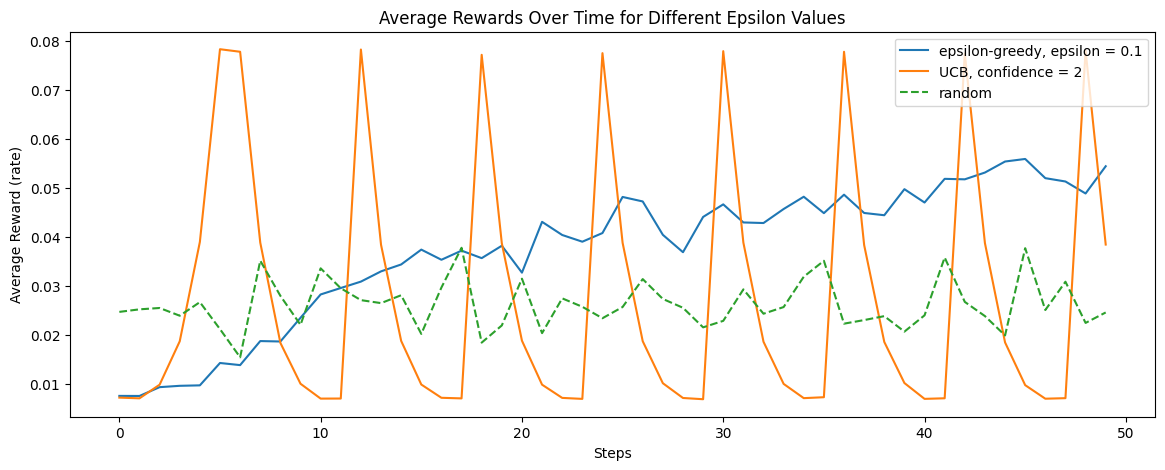

<Figure size 640x480 with 0 Axes>

In [161]:
rewards_eps, rewards_rand, rewards_ucb, values_eps, values_rand, values_ucb, counts_eps, counts_ucb, counts_rand =\
      plot_average_rewards(n_days=50, epsilon=0.1, confidence=2, num_runs=30,\
      discounts=[0.3, 0.4, 0.5, 0.6, 0.7, 0.8], reward='rate')

100%|██████████| 30/30 [00:43<00:00,  1.43s/it]


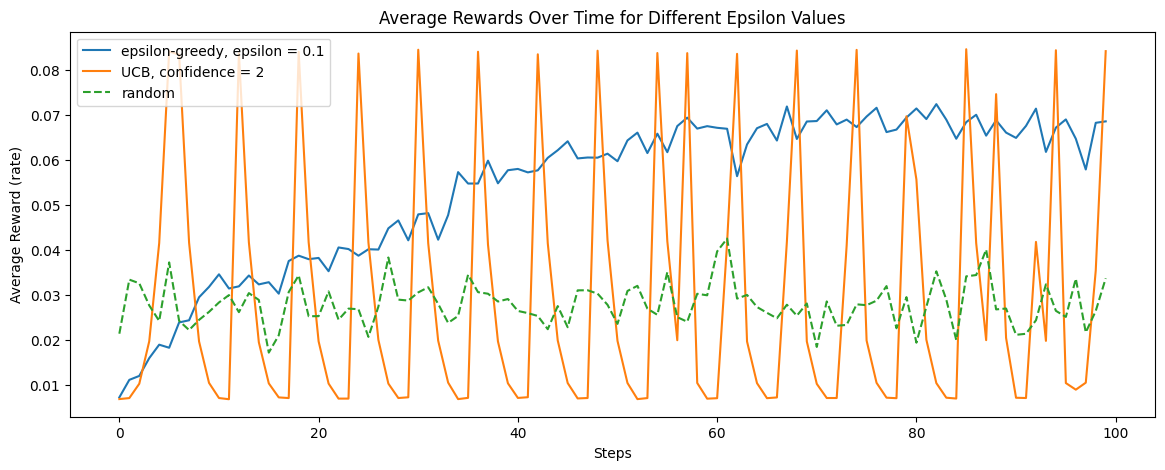

<Figure size 640x480 with 0 Axes>

In [136]:
rewards_eps, rewards_ucb, rewards_rand, values_eps, values_ucb, values_rand, counts_eps, counts_ucb, counts_rand =\
      plot_average_rewards(n_days=100, epsilon=0.1, confidence=2, num_runs=30,\
      discounts=[0.3, 0.4, 0.5, 0.6, 0.7, 0.8], reward='rate')

100%|██████████| 30/30 [00:50<00:00,  1.69s/it]


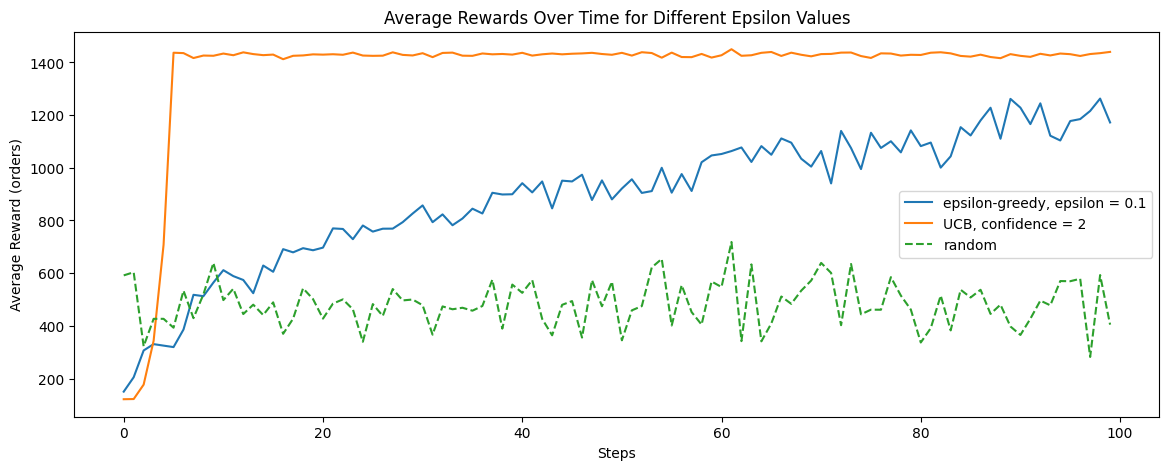

<Figure size 640x480 with 0 Axes>

In [137]:
rewards_eps, rewards_ucb, rewards_rand, values_eps, values_ucb, values_rand, counts_eps, counts_ucb, counts_rand =\
      plot_average_rewards(n_days=100, epsilon=0.1, confidence=2, num_runs=30,\
      discounts=[0.3, 0.4, 0.5, 0.6, 0.7, 0.8], reward='orders')

100%|██████████| 30/30 [00:44<00:00,  1.49s/it]


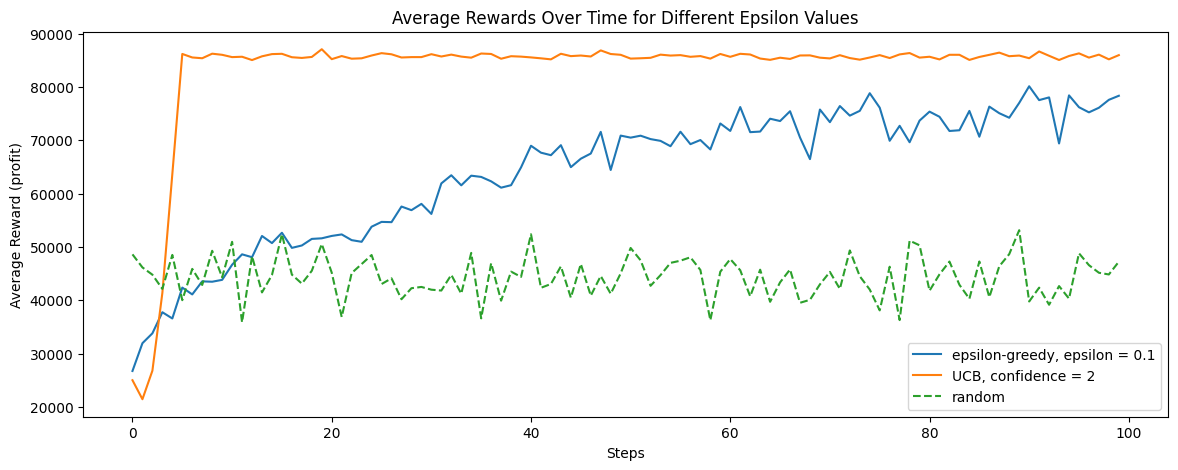

<Figure size 640x480 with 0 Axes>

In [138]:
rewards_eps, rewards_ucb, rewards_rand, values_eps, values_ucb, values_rand, counts_eps, counts_ucb, counts_rand =\
      plot_average_rewards(n_days=100, epsilon=0.1, confidence=2, num_runs=30,\
      discounts=[0.3, 0.4, 0.5, 0.6, 0.7, 0.8], reward='profit')

In [139]:
counts_eps, counts_rand, counts_ucb

(array([17.83333333,  1.66666667,  4.36666667,  5.76666667, 21.53333333,
        48.83333333]),
 array([ 1.,  1.,  1.,  1.,  1., 95.]),
 array([16.36666667, 16.9       , 15.73333333, 17.06666667, 16.66666667,
        17.26666667]))

100%|██████████| 30/30 [00:44<00:00,  1.49s/it]


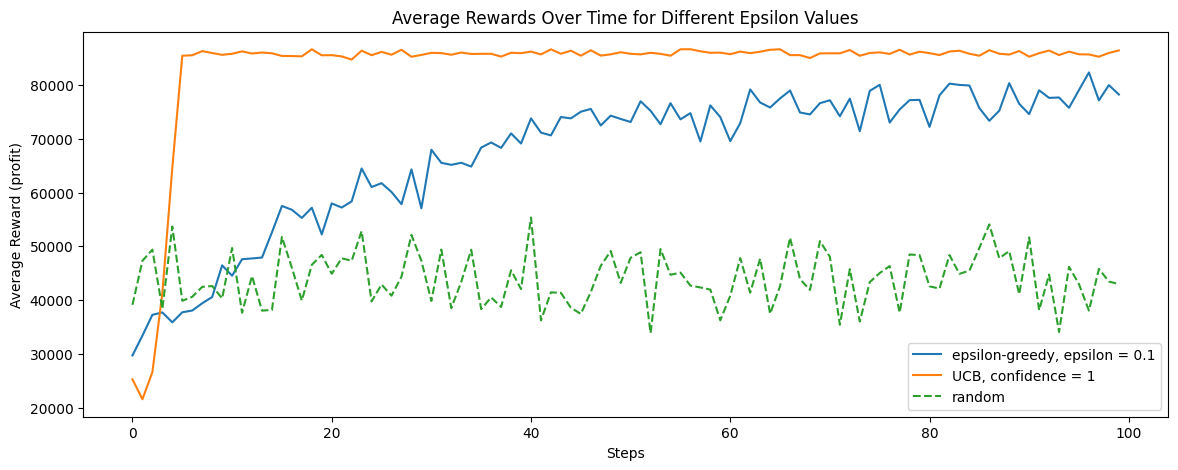

<Figure size 640x480 with 0 Axes>

In [140]:
rewards_eps, rewards_ucb, rewards_rand, values_eps, values_ucb, values_rand, counts_eps, counts_ucb, counts_rand =\
      plot_average_rewards(n_days=100, epsilon=0.1, confidence=1, num_runs=30,\
      discounts=[0.3, 0.4, 0.5, 0.6, 0.7, 0.8], reward='profit')

100%|██████████| 30/30 [02:53<00:00,  5.77s/it]


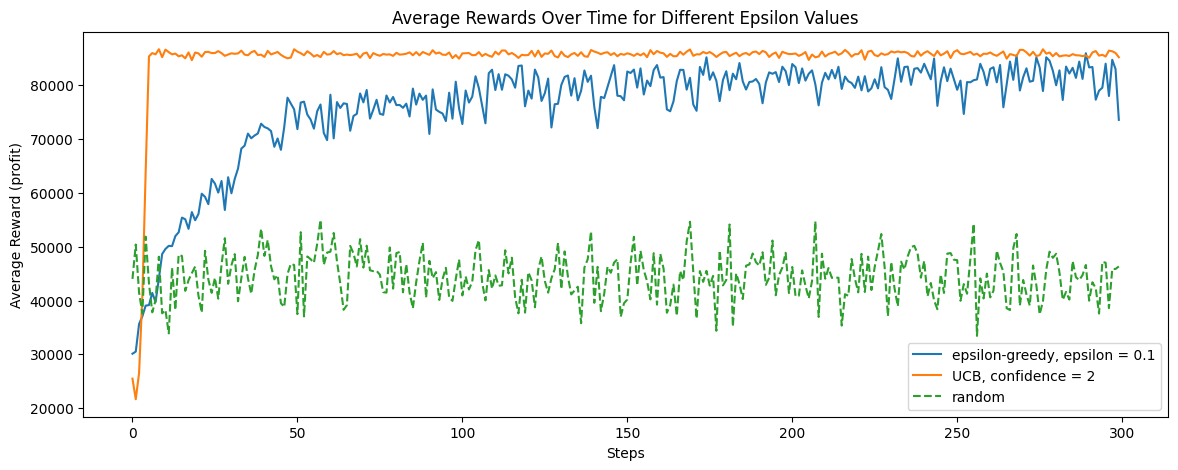

<Figure size 640x480 with 0 Axes>

In [142]:
rewards_eps, rewards_ucb, rewards_rand, values_eps, values_ucb, values_rand, counts_eps, counts_ucb, counts_rand =\
      plot_average_rewards(n_days=300, epsilon=0.1, confidence=2, num_runs=30,\
      discounts=[0.3, 0.4, 0.5, 0.6, 0.7, 0.8], reward='profit')